In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
from dsa_analysis import simulation, simulation_line, visualize, simulation_lorenz, combine_simulations, visualize, load_config
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity

%load_ext autoreload
%autoreload 2

The goal in this notebook is to study the impact of combining different shapes on the DSA metric. The idea is to create a dataset with different shapes and see how the DSA metric behaves when combining them.

## Parameters

#### Lorenz attractor simulation parameters

For each configuration, we simulate with $num\_samples$ possible initializations accross $num\_steps$ 

Parameters to compute the dissimilarity matrices and the Procrustes Alignment over Vector Fields, according to [1]

In [2]:
config = load_config('../config.yaml')

## Compositionality

We here want to analyse the evolution of the dissimilarity as a function of the number of shared motifs

### Generation of the elementary motifs

We create here elementary motifs which will be repurposed as a basis for compositional motifs later

In [3]:
# Define parameters
dt = 0.01
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']

# Run simulations line
simulations_line = simulation_line(num_steps, num_samples)

# Run simulations curve
simulations_curve = simulation_lorenz(dt, lorenz_parameters['one_attractor'][1], num_samples, num_steps)

# Run simulations Pattern1
simulations_pattern1 = simulation_lorenz(dt, lorenz_parameters['two_stable_attractors'][0], num_samples, num_steps)

# Run simulations Pattern2
simulations_pattern2 = simulation_lorenz(dt, lorenz_parameters['two_stable_attractors'][2], num_samples, num_steps)

# Run simulations line-curve-line-curve
combined_simulations_line_curve_line = combine_simulations([simulations_line, simulations_curve, np.flip(simulations_line, axis=0), np.flip(simulations_curve, axis=0)], method='attach')


# Visualize the simulations
visualize([simulations_line[0]],"line")
visualize([simulations_curve[0]],"curve")
visualize([simulations_pattern1[0]], "pattern1")
visualize([simulations_pattern2[0]], "pattern2")
visualize([combined_simulations_line_curve_line[0]],"line-curve-line")

ValueError: 'darkgreen' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [4]:
motif_basis = [
    simulations_line,
    simulations_curve,
    simulations_pattern1,
    simulations_pattern2,
    combined_simulations_line_curve_line,
]

In [5]:
# compute dissimilarity between simulations
dsa = DSA.DSA(
    motif_basis,
    n_delays=config["dsa"]["n_delays"],
    rank=config["dsa"]["rank"],
    delay_interval=config["dsa"]["delay_interval"],
    verbose=True,
    iters=1000,
    lr=1e-2,
)
dsa_scores = dsa.fit_score()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...


SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 1 and 0
Finished optimizing C
Finished optimizing C
computing similarity between DMDs 2 and 0
Finished optimizing C
Finished optimizing C
computing similarity between DMDs 2 and 1
Finished

In [6]:
# Define font sizes and styles for the plot
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

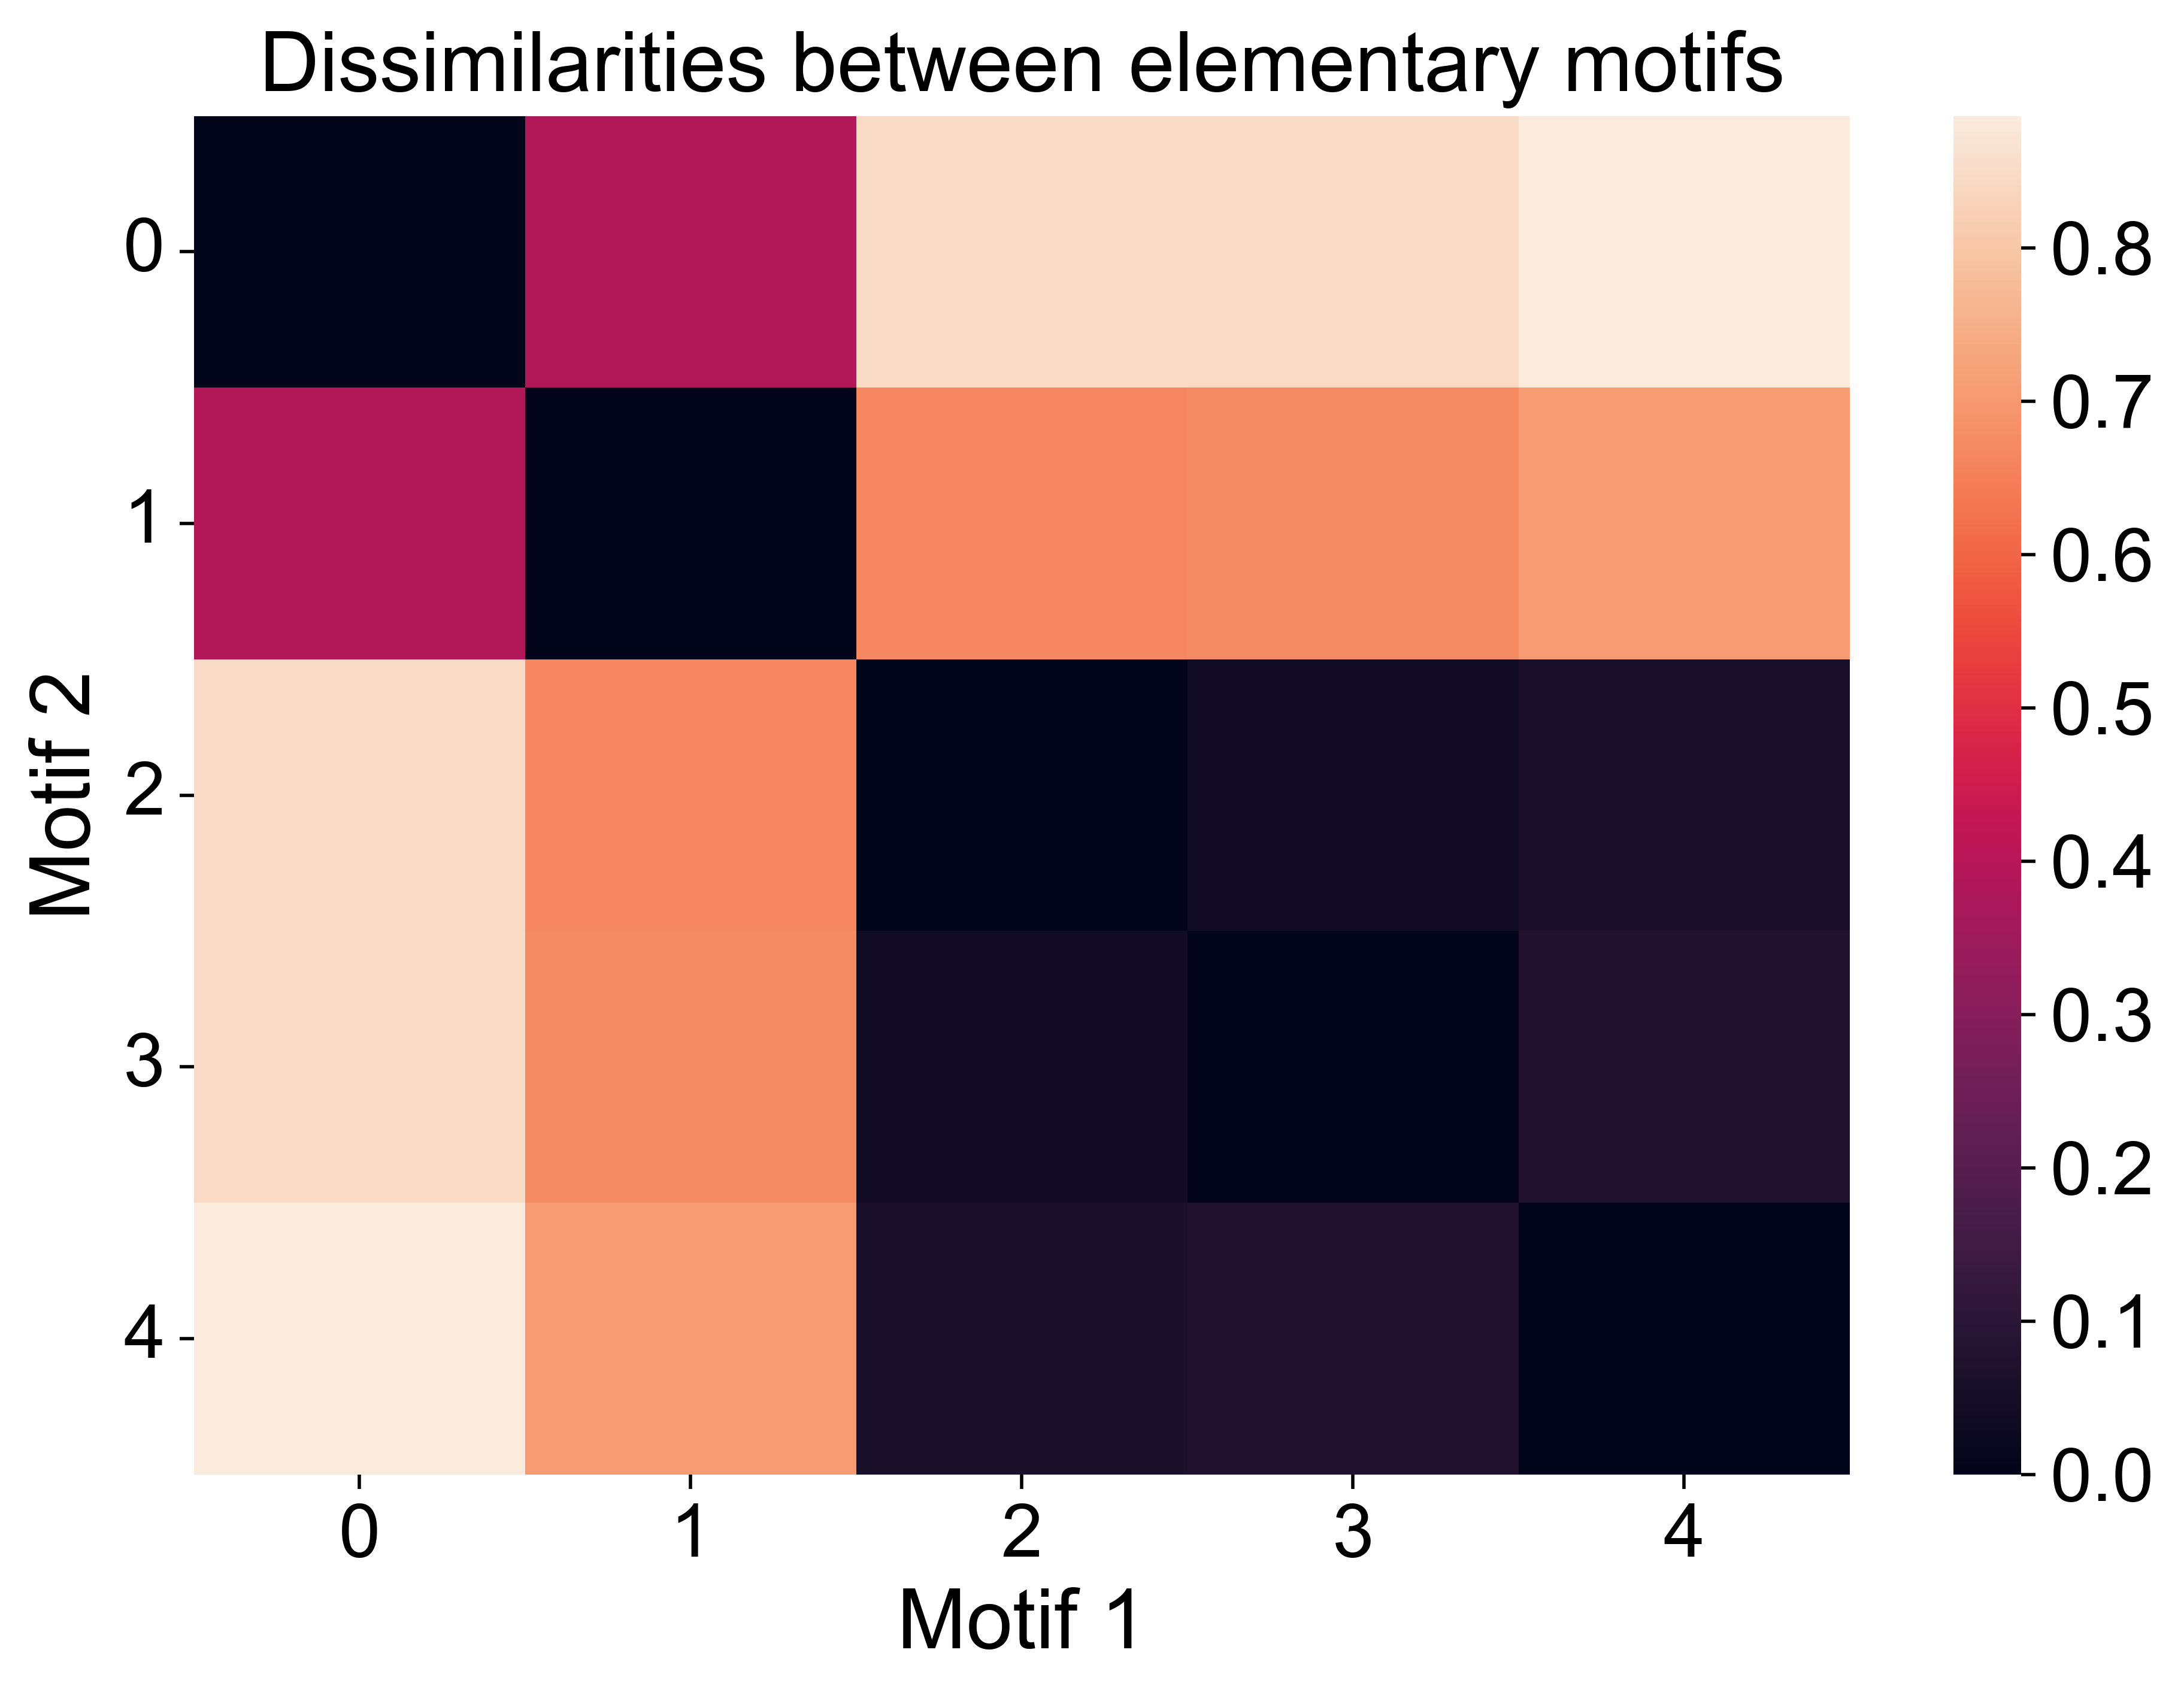

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and DPI
plt.figure(figsize=(8, 6), dpi=500)

# Create the heatmap
sns.heatmap(dsa_scores)

# Set the title and labels
plt.title("Dissimilarities between elementary motifs")
plt.xlabel("Motif 1")
plt.ylabel("Motif 2")

# Adjust tick labels
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Adjust layout and display
plt.tight_layout()
plt.show()

### Generation of the possible compositional motifs

We here genetate all the possible permutations of $3$ different motifs among the $5$ elementary motifs. We hence have $5 \times 4 \times 3 = 60$ possible compositions.

In [8]:
combine_pattern_curve = combine_simulations([simulations_line, simulations_pattern1], method='attach')

In [9]:
motif_basis = [simulations_line, simulations_curve, simulations_pattern1,simulations_pattern2,combined_simulations_line_curve_line]
motif_names = ['Line', 'Curve', 'Pattern1', 'Pattern2','Line-Curve-Line-Curve']
motif_dict = {motif_names[i]: motif_basis[i] for i in range(len(motif_basis))}
all_simulations_length_3 = list(permutations(motif_names, 3))

In [10]:
all_simulations_combined = {permutation: combine_simulations([motif_dict[permutation[0]], motif_dict[permutation[1]], motif_dict[permutation[2]]],method='attach') for permutation in all_simulations_length_3}

One out of $60$ possible combinations

In [11]:
visualize([list(all_simulations_combined.values())[0][0]],"all simulations combined")

ValueError: 'darkgreen' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

### DSA computation

We here measure the similarity between the 60 compositional motifs : 
- the three independant patterns, namely a line, curve and a lorenz pattern
- A combination of each 

In [ ]:
model = list(all_simulations_combined.values())
model_names = list(all_simulations_combined.keys())

In [ ]:
procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
dissimilarities_pa = np.empty((len(model),len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        dissimilarities_pa[i,j] = 1-procrustes_measure(model[i], model[j])

In [ ]:
cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
dissimilarities_cka= np.empty((len(model), len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        dissimilarities_cka[i, j] = 1-cka_measure(model[i], model[j])

arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.8052196989439564 0.6347504498459907 0.1947803010560436
arccos score: 0.6661098511234055 0.8418154676670896 0.3338901488765945
arccos score: 0.6999933008292734 0.7954082108563646 0.30000669917072664
arccos score: 0.5603676338093636 0.9759667220237789 0.4396323661906364
arccos score: 0.6741962050181486 0.8309205046090292 0.3258037949818514
arccos score: 0.6306893819467859 0.8883550972545061 0.3693106180532141
arccos score: 0.5782718759761905 0.9541874338985787 0.42172812402380955
arccos score: 0.6322368840438559 0.886359364616435 0.3677631159561441
arccos score: 0.5204323708403993 1.0234391075666138 0.4795676291596007
arccos score: 0.8383732549367777 0.5765043139518149 0.16162674506322228
arccos score: 0.6955153937895437 0.8016593668456117 0.30448460621045625
arccos score: 0.15550593326674 1.4146567303130693 0.84449406673326
arccos score: 0.03393984995587018 1.5368499574976768 0.9660601500441298
arccos score: 0.01222072735

In [ ]:
path = "../data/dsa_results/50_33_6.csv"

df = pd.read_csv(path)
df.rename(
    columns={"number of shared elements": "number_of_shared_elements"}, inplace=True
)
data_all = (
    df.dropna()
)  # plot on a single plot the Median similarity vs Number of shared elements for pair  (n_delay, delay_interval)
dissimilarities_dsa = (
    data_all.groupby(["number_of_shared_elements"])["similarity"].mean().reset_index()
)
dissimilarities_dsa_standard_error = (
    data_all.groupby(["number_of_shared_elements"])["similarity"].sem().reset_index()
)

### Dissimilarity VS number of shared elements

We group here the compositional motifs by number of shared elements

In [ ]:
grouped_by_shared_elements_unordered = {i:[] for i in range(4)}
for comp_motif_1 in model_names:
    for comp_motif_2 in model_names:
        if model_names.index(comp_motif_1) != model_names.index(comp_motif_2):
            set_1 = set(comp_motif_1)
            set_2 = set(comp_motif_2)
            grouped_by_shared_elements_unordered[len(set_1.intersection(set_2))].extend([(comp_motif_1, comp_motif_2)])

In [ ]:
dissimilarities_pa_grouped_by_shared_elements_unordered = {i:[] for i in range(1,4)}
for key in grouped_by_shared_elements_unordered:
    for tuple1, tuple2 in grouped_by_shared_elements_unordered[key]:
        similarity_pa = dissimilarities_pa[model_names.index(tuple1), model_names.index(tuple2)]
        dissimilarities_pa_grouped_by_shared_elements_unordered[key].append(similarity_pa)

dissimilarities_cka_grouped_by_shared_elements_unordered = {i: [] for i in range(1, 4)}
for key in grouped_by_shared_elements_unordered:
    for tuple1, tuple2 in grouped_by_shared_elements_unordered[key]:
        similarity_cka = dissimilarities_cka[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_cka_grouped_by_shared_elements_unordered[key].append(similarity_cka)

In [ ]:
mean_dissimilarities_pa = {
    key: np.mean(value)
    for key, value in dissimilarities_pa_grouped_by_shared_elements_unordered.items()
}
standard_error_dissimilarities_pa = {
    key: np.std(value, ddof=1) / np.sqrt(len(value))
    for key, value in dissimilarities_pa_grouped_by_shared_elements_unordered.items()
}
mean_dissimilarities_cka = {
    key: np.mean(value)
    for key, value in dissimilarities_cka_grouped_by_shared_elements_unordered.items()
}
standard_error_dissimilarities_cka = {
    key: np.std(value, ddof=1) / np.sqrt(len(value))
    for key, value in dissimilarities_cka_grouped_by_shared_elements_unordered.items()
}

In [ ]:
dissimilarity_pa = pd.DataFrame({"number_of_shared_elements": list(mean_dissimilarities_pa.keys()), "similarity": list(mean_dissimilarities_pa.values()), "standard_error": list(standard_error_dissimilarities_pa.values())})
dissimilarity_cka = pd.DataFrame({"number_of_shared_elements": list(mean_dissimilarities_cka.keys()), "similarity": list(mean_dissimilarities_cka.values()), "standard_error": list(standard_error_dissimilarities_cka.values())})


In [ ]:
dissimilarities_dsa

,number_of_shared_elements,similarity
0,1,0.764701
1,2,0.628051
2,3,0.360683


In [ ]:
dissimilarity_pa["number_of_shared_elements"].tolist()[-1]

3

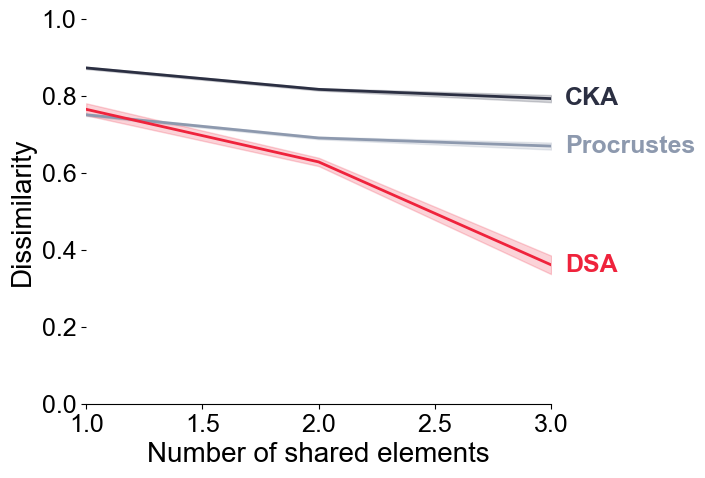

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Define a color palette:
colors = ["#8D99AE", "#2B2F42", "#EF233C"]  # Greys for CKA and Procrustes, Red for DSA

# Plot for Procrustes Angular in grey
ax.plot(
    dissimilarity_pa["number_of_shared_elements"],
    dissimilarity_pa["similarity"],
    label="Procrustes Angular",
    linestyle="-",
    color=colors[0],  # Grey color
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    dissimilarity_pa["number_of_shared_elements"],
    dissimilarity_pa["similarity"] - dissimilarity_pa["standard_error"],
    dissimilarity_pa["similarity"] + dissimilarity_pa["standard_error"],
    color=colors[0],
    alpha=0.2,  # Color and transparency of the shaded area
)

# Plot for CKA Angular in another grey
ax.plot(
    dissimilarity_cka["number_of_shared_elements"],
    dissimilarity_cka["similarity"],
    label="CKA Angular",
    linestyle="-",
    color=colors[1],  # Darker grey color
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    dissimilarity_cka["number_of_shared_elements"],
    dissimilarity_cka["similarity"] - dissimilarity_cka["standard_error"],
    dissimilarity_cka["similarity"] + dissimilarity_cka["standard_error"],
    color=colors[1],
    alpha=0.2,  # Color and transparency of the shaded area
)

# Plot for DSA in red to stand out
ax.plot(
    dissimilarities_dsa["number_of_shared_elements"],
    dissimilarities_dsa["similarity"],
    label="DSA",
    linestyle="-",
    color=colors[2],  # Red color
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    dissimilarities_dsa["number_of_shared_elements"],
    dissimilarities_dsa["similarity"]
    - dissimilarities_dsa_standard_error["similarity"],
    dissimilarities_dsa["similarity"]
    + dissimilarities_dsa_standard_error["similarity"],
    color=colors[2],
    alpha=0.2,  # Color and transparency of the shaded area
)

# Annotate each line with its label slightly to the right of the last data point
for i, (dissimilarity, label) in enumerate(
    zip(
        [dissimilarity_pa, dissimilarity_cka, dissimilarities_dsa],
        ["Procrustes", "CKA", "DSA"],
    )
):
    ax.text(
        dissimilarity["number_of_shared_elements"].tolist()[-1]
        * 1.02,  # Slightly to the right of the last point
        dissimilarity["similarity"].tolist()[-1],
        label,
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the bottom spine
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Set axis limits to ensure the bottom x-axis starts at 1 and ends at 3
ax.set_xlim(1, 3)
ax.set_ylim(0, 1)

# Ensure the bottom spine aligns correctly with the axis limits
ax.spines["bottom"].set_position(("outward", 0))  # Align spine with limits

# Set axis labels
ax.set_xlabel("Number of shared elements")
ax.set_ylabel("Dissimilarity")

# Save the plot as a high-resolution image
plt.savefig("dissimilarity_vs_shared_elements.png", dpi=300)
plt.show()

### Ordered

In [ ]:
path = "../data/dsa_results/50_17_11_ordered.csv"

df = pd.read_csv(path)
df.rename(
    columns={"number of shared elements": "number_of_shared_elements"}, inplace=True
)
data_all = (
    df.dropna()
)  # plot on a single plot the Median similarity vs Number of shared elements for pair  (n_delay, delay_interval)
dissimilarities_dsa = (
    data_all.groupby(["number_of_shared_elements"])["similarity"].mean().reset_index()
)
dissimilarities_dsa_standard_error = (
    data_all.groupby(["number_of_shared_elements"])["similarity"].sem().reset_index()
)

In [ ]:
def same_order(comp_motif_1, comp_motif_2) -> bool:
    return len(
        [i for i in range(len(comp_motif_1)) if comp_motif_1[i] == comp_motif_2[i]]
    )

In [ ]:
grouped_by_shared_elements_ordered = {i: [] for i in range(0,4)}
for comp_motif_1 in model_names:
    for comp_motif_2 in model_names:
        grouped_by_shared_elements_ordered[same_order(comp_motif_1, comp_motif_2)].extend(
            [(comp_motif_1, comp_motif_2)]
        )

In [ ]:
dissimilarities_pa_grouped_by_shared_elements_ordered = {i: [] for i in range(0, 4)}
for key in grouped_by_shared_elements_ordered:
    for tuple1, tuple2 in grouped_by_shared_elements_ordered[key]:
        similarity_pa = dissimilarities_pa[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_pa_grouped_by_shared_elements_ordered[key].append(
            similarity_pa
        )

dissimilarities_cka_grouped_by_shared_elements_ordered = {i: [] for i in range(0, 4)}
for key in grouped_by_shared_elements_ordered:
    for tuple1, tuple2 in grouped_by_shared_elements_ordered[key]:
        similarity_cka = dissimilarities_cka[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_cka_grouped_by_shared_elements_ordered[key].append(
            similarity_cka
        )

In [ ]:
mean_dissimilarities_pa_ordered = {
    key: np.mean(value)
    for key, value in dissimilarities_pa_grouped_by_shared_elements_ordered.items()
}
standard_errors_dissimilarities_pa_ordered = {
    key: np.std(value, ddof=1) / np.sqrt(len(value))
    for key, value in dissimilarities_pa_grouped_by_shared_elements_ordered.items()
}
mean_dissimilarities_cka_ordered = {
    key: np.mean(value)
    for key, value in dissimilarities_cka_grouped_by_shared_elements_ordered.items()
}
standard_errors_dissimilarities_cka_ordered = {
    key: np.std(value, ddof=1) / np.sqrt(len(value))
    for key, value in dissimilarities_cka_grouped_by_shared_elements_ordered.items()
}

In [ ]:
dissimilarity_pa = pd.DataFrame(
    {
        "number_of_shared_elements": list(mean_dissimilarities_pa_ordered.keys()),
        "similarity": list(mean_dissimilarities_pa_ordered.values()),
        "standard_error": list(standard_errors_dissimilarities_pa_ordered.values()),
    }
)
dissimilarity_cka = pd.DataFrame(
    {
        "number_of_shared_elements": list(mean_dissimilarities_cka_ordered.keys()),
        "similarity": list(mean_dissimilarities_cka_ordered.values()),
        "standard_error": list(standard_errors_dissimilarities_cka_ordered.values()),
    }
)

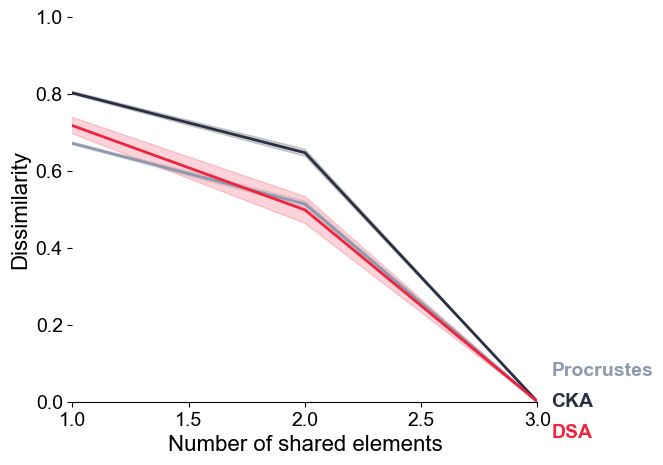

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Define a color palette:
colors = ["#8D99AE", "#2B2F42", "#EF233C"]  # Greys for CKA and Procrustes, Red for DSA

# Plot for Procrustes Angular in grey
ax.plot(
    dissimilarity_pa["number_of_shared_elements"],
    dissimilarity_pa["similarity"],
    label="Procrustes Angular",
    linestyle="-",
    color=colors[0],  # Grey color
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    dissimilarity_pa["number_of_shared_elements"],
    dissimilarity_pa["similarity"] - dissimilarity_pa["standard_error"],
    dissimilarity_pa["similarity"] + dissimilarity_pa["standard_error"],
    color=colors[0],
    alpha=0.2,  # Color and transparency of the shaded area
)

# Plot for CKA Angular in another grey
ax.plot(
    dissimilarity_cka["number_of_shared_elements"],
    dissimilarity_cka["similarity"],
    label="CKA Angular",
    linestyle="-",
    color=colors[1],  # Darker grey color
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    dissimilarity_cka["number_of_shared_elements"],
    dissimilarity_cka["similarity"] - dissimilarity_cka["standard_error"],
    dissimilarity_cka["similarity"] + dissimilarity_cka["standard_error"],
    color=colors[1],
    alpha=0.2,  # Color and transparency of the shaded area
)

# Plot for DSA in red to stand out
ax.plot(
    dissimilarities_dsa["number_of_shared_elements"],
    dissimilarities_dsa["similarity"],
    label="DSA",
    linestyle="-",
    color=colors[2],  # Red color
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    dissimilarities_dsa["number_of_shared_elements"],
    dissimilarities_dsa["similarity"]
    - dissimilarities_dsa_standard_error["similarity"],
    dissimilarities_dsa["similarity"]
    + dissimilarities_dsa_standard_error["similarity"],
    color=colors[2],
    alpha=0.2,  # Color and transparency of the shaded area
)

# Annotate each line with its label slightly to the right of the last data point, offset vertically
vertical_offsets = [0.08, 0, -0.08]  # Adjust these to space out the labels vertically
for i, (dissimilarity, label, offset) in enumerate(
    zip(
        [dissimilarity_pa, dissimilarity_cka, dissimilarities_dsa],
        ["Procrustes", "CKA", "DSA"],
        vertical_offsets,
    )
):
    ax.text(
        dissimilarity["number_of_shared_elements"].tolist()[-1]
        * 1.02,  # Slightly to the right of the last point
        dissimilarity["similarity"].tolist()[-1] + offset,  # Offset vertically
        label,
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the bottom spine
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Set axis limits to ensure the bottom x-axis starts at 1 and ends at 3
ax.set_xlim(1, 3)
ax.set_ylim(0, 1)

# Ensure the bottom spine aligns correctly with the axis limits
ax.spines["bottom"].set_position(("outward", 0))  # Align spine with limits

# Set axis labels
ax.set_xlabel("Number of shared elements")
ax.set_ylabel("Dissimilarity")

# Save the plot as a high-resolution image
plt.savefig("dissimilarity_vs_shared_elements.png", dpi=300)
plt.show()

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 